In [1]:
import cv2
import time
import numpy as np
import pandas as pd
import seaborn as sb
from warnings import *
filterwarnings("ignore")
import  tensorflow   as  tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from  tensorflow.keras.regularizers import L2

In [2]:
train,test ,valid= tfds.load("dtd",split=['train[:80%]','train[:90%]','train[90%:]'],batch_size=-1)
print("Done!")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/dtd/3.0.1.incomplete89XO5K/dtd-train.tfrecord*...:   0%|          | 0/1880…

Generating test examples...:   0%|          | 0/1880 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/dtd/3.0.1.incomplete89XO5K/dtd-test.tfrecord*...:   0%|          | 0/1880 …

Generating validation examples...:   0%|          | 0/1880 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/dtd/3.0.1.incomplete89XO5K/dtd-validation.tfrecord*...:   0%|          | 0…

Dataset dtd downloaded and prepared to /root/tensorflow_datasets/dtd/3.0.1. Subsequent calls will reuse this data.
Done!


In [3]:
print(f"Shape : {train['image'].shape} images ;\n\n Train : {len(train['image'])} images  ;\n\n Test : {len(test['image'])} images ;\n\n Label : 1000 classes ; ")

Shape : (1504, 701, 800, 3) images ;

 Train : 1504 images  ;

 Test : 1692 images ;

 Label : 1000 classes ; 


In [4]:
datas = tfds.builder('dtd')
info = datas.info
print(info)

tfds.core.DatasetInfo(
    name='dtd',
    full_name='dtd/3.0.1',
    description="""
    The Describable Textures Dataset (DTD) is an evolving collection of textural
    images in the wild, annotated with a series of human-centric attributes,
    inspired by the perceptual properties of textures. This data is made available
    to the computer vision community for research purposes.
    
    The "label" of each example is its "key attribute" (see the official website).
    The official release of the dataset defines a 10-fold cross-validation
    partition. Our TRAIN/TEST/VALIDATION splits are those of the first fold.
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/dtd/index.html',
    data_path='/root/tensorflow_datasets/dtd/3.0.1',
    file_format=tfrecord,
    download_size=596.28 MiB,
    dataset_size=603.00 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': C

In [5]:
num_classes = info.features['label'].num_classes
labels = []
for i in range(num_classes):
    labels.append(info.features['label'].int2str(i))
len(labels)

47

In [6]:
train_data,train_label = tfds.as_numpy(train['image']),tfds.as_numpy(train['label'])
test_data,test_label = tfds.as_numpy(test['image']),tfds.as_numpy(test['label'])
val_data,val_label = tfds.as_numpy(valid['image']),tfds.as_numpy(valid['label'])

In [7]:
def resizing(images):
    im_data = []
    for image in images:
      img = cv2.resize(image,(224,224),interpolation=cv2.INTER_AREA)
      im_data.append(img)
    return im_data
def preprocess(imgs,labs):
    imgs = np.array(imgs)
    imgs = imgs/255.0
    imgs = imgs.astype('float16')
    labs = np.array(labs)
    label = labs.astype("uint16")
    return imgs,label

In [8]:
x_train = resizing(train_data)
x_test = resizing(test_data)
x_val = resizing(val_data)

In [9]:
x_train,y_train = preprocess(x_train,train_label)
x_test,y_test = preprocess(x_test,test_label)
x_val,y_val = preprocess(x_val,val_label)

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_label)).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_label)).batch(32)

val_ds = tf.data.Dataset.from_tensor_slices((x_val,val_label)).batch(32)

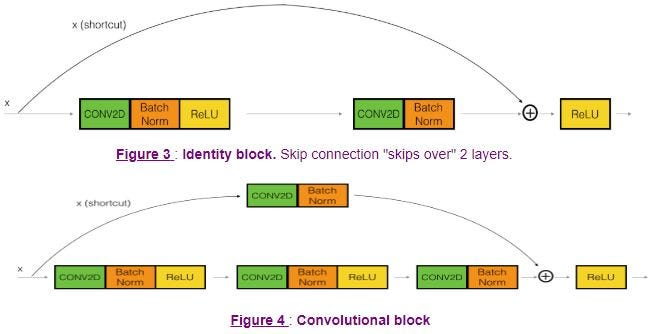

In [11]:
def convolution_block(inputs_,Filters,stage,block,n=2):
    X_inp = inputs_
    namec= "convstage_"+str(stage)+block+'_section'
    nameb="batchstage_"+str(stage)+block+'_section'
    #body_part
    c_1= tf.keras.layers.Conv2D(Filters[0],(1,1),(n,n),padding='valid',kernel_regularizer=L2(l=0.01),name=namec+'1a')(inputs_)
    b_1 = tf.keras.layers.BatchNormalization(axis=3,name=nameb+'1a')(c_1)
    a_1 = tf.keras.layers.Activation('relu')(b_1)

    c_2 = tf.keras.layers.Conv2D(Filters[1],(3,3),(1,1),padding='same',kernel_regularizer=L2(l=0.01),name=namec+'1b')(a_1)
    b_2 = tf.keras.layers.BatchNormalization(axis=3,name=nameb+'1b')(c_2)
    a_2 = tf.keras.layers.Activation('relu')(b_2)

    c_3 = tf.keras.layers.Conv2D(Filters[2],(1,1),(1,1),padding='valid',kernel_regularizer=L2(l=0.01),name=namec+'1c')(a_2)
    b_3 = tf.keras.layers.BatchNormalization(axis=3,name=nameb+'1c')(c_3)
    # output
    c_out = tf.keras.layers.Conv2D(Filters[2],(1,1),(n,n),padding='valid',kernel_regularizer=L2(l=0.01),name=namec+'1d')(X_inp)
    b_out = tf.keras.layers.BatchNormalization(axis=3,name=nameb+'1d')(c_out)

    x_out = tf.keras.layers.Add()([b_3,b_out])

    output = tf.keras.layers.Activation('relu')(x_out)

    return output

In [12]:
def identity_block(inputs_,Filters,stage,block):
    X_input = inputs_
    c_name= "convstage_"+str(stage)+block+'_section'
    b_name="batchstage_"+str(stage)+block+'_section'
    #body_part
    c_1= tf.keras.layers.Conv2D(Filters[0],(1,1),(1,1),padding='valid',kernel_regularizer=L2(l=0.01),name=c_name+'2a')(inputs_)
    b_1 = tf.keras.layers.BatchNormalization(axis=3,name=b_name+'2a')(c_1)
    a_1 = tf.keras.layers.Activation('relu')(b_1)

    c_2 = tf.keras.layers.Conv2D(Filters[1],(3,3),(1,1),padding='same',kernel_regularizer=L2(l=0.01),name=c_name+'2b')(a_1)
    b_2 = tf.keras.layers.BatchNormalization(axis=3,name=b_name+'2b')(c_2)
    a_2 = tf.keras.layers.Activation('relu')(b_2)

    c_3 = tf.keras.layers.Conv2D(Filters[2],(1,1),(1,1),padding='valid',kernel_regularizer=L2(l=0.01),name=c_name+'2c')(a_2)
    b_3 = tf.keras.layers.BatchNormalization(axis=3,name=b_name+'2c')(c_3)
    # output

    x_concat = tf.keras.layers.Add()([b_3,X_input])

    output = tf.keras.layers.Activation('relu')(x_concat)

    return output

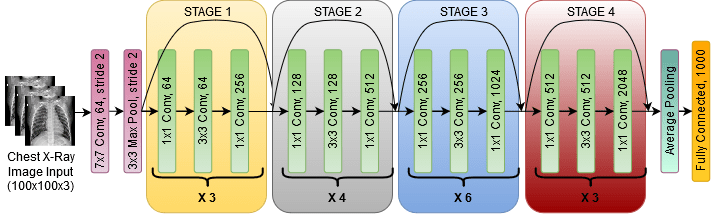

In [13]:
class ResNet(tf.keras.Model):
    def __init__(self, input_shape, classes):

        super(ResNet, self).__init__(name="resudial_Network_50")

        self.inputs_1 = tf.keras.layers.Input(shape=input_shape)
        self.classes = classes
        X=tf.keras.layers.ZeroPadding2D()(self.inputs_1)
        X=tf.keras.layers.Conv2D(64,(7, 7),padding='valid',name="stage_1_conv_block_1",strides=2,kernel_regularizer=L2(l=0.01))(X)
        X=tf.keras.layers.BatchNormalization()(X)
        X=tf.keras.layers.Activation('relu')(X)
        X=tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=2)(X)

        X = convolution_block(X,Filters=[64,64,256],stage=2,block='A',n=1)
        X = identity_block(X,Filters=[64,64,256],stage=2,block="B")
        X = identity_block(X,Filters=[64,64,256],stage=2,block="C")

        # Stage 3 = 4x
        X = convolution_block(X,Filters=[128,128,512],stage=3,block='A')
        X = identity_block(X,Filters=[128,128,512],stage=3,block="B")
        X = identity_block(X,Filters=[128,128,512],stage=3,block="C")
        X = identity_block(X,Filters=[128,128,512],stage=3,block="D")

        # Stage 4 = 6x
        X = convolution_block(X,Filters=[256,256,1024],stage=4,block='A')
        X = identity_block(X,Filters=[256,256,1024],stage=4,block="B")
        X = identity_block(X,Filters=[256,256,1024],stage=4,block="C")
        X = identity_block(X,Filters=[256,256,1024],stage=4,block="D")
        X = identity_block(X,Filters=[256,256,1024],stage=4,block="E")
        X = identity_block(X,Filters=[256,256,1024],stage=4,block="F")

        # Stage 5 = 3x
        X = convolution_block(X,Filters=[512,512,2048],stage=5,block='A')
        X = identity_block(X,Filters=[512,512,2048],stage=5,block="B")
        X = identity_block(X,Filters=[512,512,2048],stage=5,block="C")
        # Stage 6
        X = tf.keras.layers.AveragePooling2D(pool_size=(1,1))(X)
        X = tf.keras.layers.Activation('relu')(X)
        X = tf.keras.layers.Flatten()(X)

        output_layer = tf.keras.layers.Dense(self.classes, activation='softmax')(X)

        self.resnet = tf.keras.Model(inputs=self.inputs_1, outputs=output_layer)

    def call(self,x):
        return self.resnet(x)

In [14]:
classes=len(labels)
input_size=(224,224,3)
resnet_model = ResNet(input_size, classes)


In [15]:
resnet_model.build((None,224,224,3))
resnet_model.summary()

Model: "resudial_Network_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 47)                28304303  
                                                                 
Total params: 28,304,303
Trainable params: 28,251,183
Non-trainable params: 53,120
_________________________________________________________________


In [16]:
#compiler
Optimizer  = tf.keras.optimizers.Adam(learning_rate=0.001)
sparse = tf.keras.losses.SparseCategoricalCrossentropy()

# train objects
loss_obj = tf.keras.metrics.Mean(name='loss')
accuracy_obj = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

# test objects
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [17]:
@tf.function
def training(images, labels):
    with tf.GradientTape() as tape:
        predict = resnet_model(images, training=True)
        loss_1 = sparse(labels, predict)
    gradients = tape.gradient(loss_1,resnet_model.trainable_variables)
    Optimizer.apply_gradients(zip(gradients, resnet_model.trainable_variables))
    loss_obj(loss_1)
    accuracy_obj(labels, predict)

In [18]:
@tf.function
def testing(images, labels):
    prediction= resnet_model(images, training=False)
    valid_loss = sparse(labels, prediction)
    val_loss(valid_loss)
    val_accuracy(labels, prediction)

In [19]:
accuracies = []
val_accuracies=[]
losses=[]
val_losses=[]
epochs = 10

In [20]:
# model fitting
import time
for epoch in range(epochs):
  print(f"Epoch : {epoch+1}/{epochs} ")
  #training
  start_sec = time.time()
  start_ms = time.perf_counter() * 1000
  accuracy_obj.reset_states()
  loss_obj.reset_states()
  val_accuracy.reset_states()
  val_loss.reset_states()
  for  i , j in train_ds:
    training(i,j)
  accuracies.append(accuracy_obj.result())
  losses.append(loss_obj.result())


  #testing
  for  i , j in test_ds:
     testing(i,j)

  val_accuracies.append(val_accuracy.result())
  val_losses.append(val_loss.result())


  end_sec = time.time()
  end_ms = time.perf_counter() * 1000
  sec = end_sec-start_sec
  ms = end_ms-start_ms
  seconds = int(sec)
  mil_sec = int(ms%1000)
  print(f"[=>=>=>=>=>=>=>=>=>=>=>=>] {seconds} s {mil_sec}ms/step - loss : {loss_obj.result()} - accuracy : {accuracy_obj.result()} - val_loss : {val_loss.result()} - val_acc : {val_accuracy.result()}")
print(f"Training finished your final test loss is --- {((val_losses[-1])*100)} % --- and  test_accuracy --- {((val_accuracies[-1])*100)} %  " )

Epoch : 1/10 
[=>=>=>=>=>=>=>=>=>=>=>=>] 73 s 540ms/step - loss : 23.053253173828125 - accuracy : 0.025265958160161972 - val_loss : 112.03502655029297 - val_acc : 0.02364066243171692
Epoch : 2/10 
[=>=>=>=>=>=>=>=>=>=>=>=>] 18 s 477ms/step - loss : 7.878830909729004 - accuracy : 0.029255319386720657 - val_loss : 3.9054996967315674 - val_acc : 0.024231677874922752
Epoch : 3/10 
[=>=>=>=>=>=>=>=>=>=>=>=>] 18 s 600ms/step - loss : 5.404763221740723 - accuracy : 0.02393617108464241 - val_loss : 3.8683388233184814 - val_acc : 0.02186761237680912
Epoch : 4/10 
[=>=>=>=>=>=>=>=>=>=>=>=>] 18 s 535ms/step - loss : 4.042879581451416 - accuracy : 0.0485372357070446 - val_loss : 3.85732102394104 - val_acc : 0.030732860788702965
Epoch : 5/10 
[=>=>=>=>=>=>=>=>=>=>=>=>] 18 s 450ms/step - loss : 3.831925630569458 - accuracy : 0.07247340679168701 - val_loss : 3.823488712310791 - val_acc : 0.040780141949653625
Epoch : 6/10 
[=>=>=>=>=>=>=>=>=>=>=>=>] 18 s 450ms/step - loss : 3.6556642055511475 - accura

In [22]:
for valid_img, valid_labels in val_ds:
    testing(valid_img, valid_labels)
print(f"test_loss:  ~{val_loss.result()}\ntest_accuracy: {val_accuracy.result()}")

test_loss:  ~3.898376703262329
test_accuracy: 0.12978723645210266


In [23]:
def hist(losses):
    hist_loss =[]
    for i in losses:
      hist_loss.append(i.numpy())
    return hist_loss

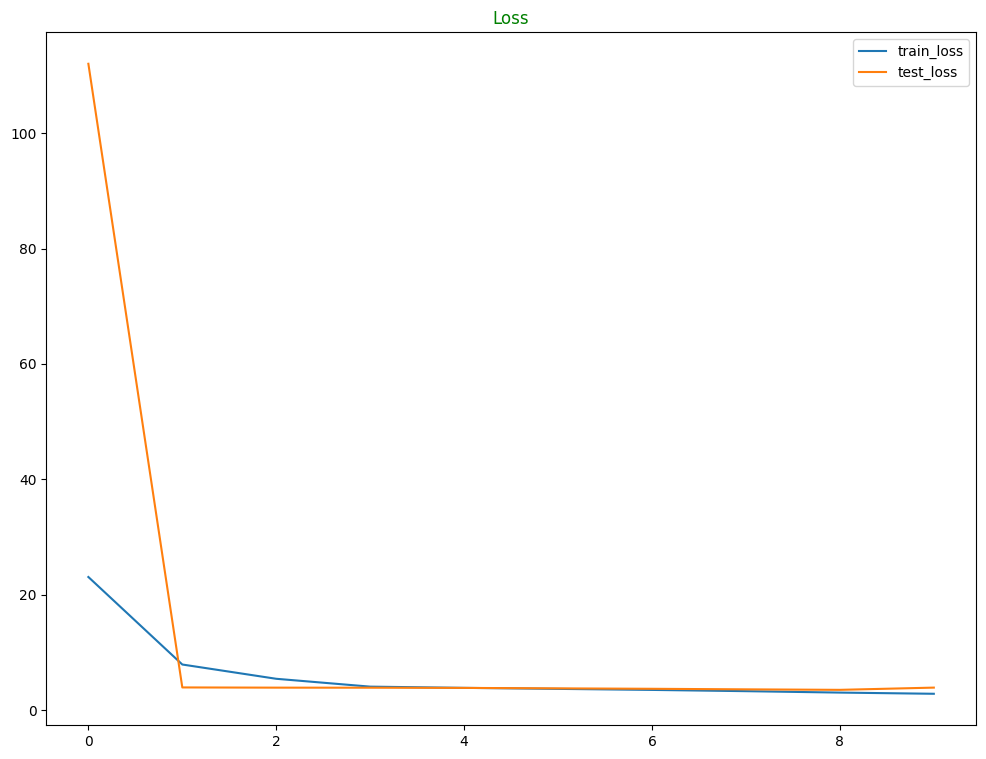

In [24]:
my_losses= hist(losses)
my_test_losses= hist(val_losses)
Epochs = [i for i in range(epochs)]
plt.figure(figsize=(12,9))
plt.title("Loss",color='green')
plt.plot(Epochs,my_losses)
plt.plot(Epochs,my_test_losses)
plt.legend(['train_loss','test_loss'],loc="best")
plt.show()

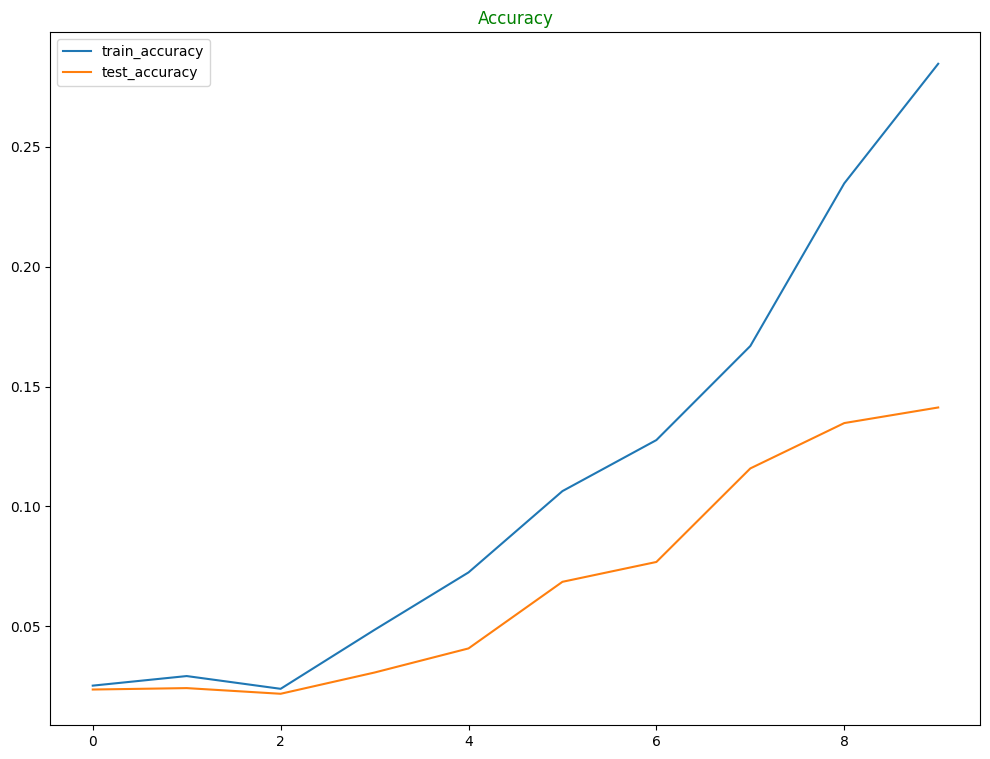

In [25]:
my_accuracies= hist(accuracies)
my_test_accuracies= hist(val_accuracies)
Epochs = [i for i in range(epochs)]
plt.figure(figsize=(12,9))
plt.title("Accuracy",color='green')
plt.plot(Epochs,my_accuracies)
plt.plot(Epochs,my_test_accuracies)
plt.legend(['train_accuracy','test_accuracy'],loc="best")
plt.show()

In [27]:
predictions = resnet_model.predict(val_ds)
preds =[]
for i in predictions:
  preds.append(np.argmax(i))

6/6 [==============================] - 1s 92ms/step


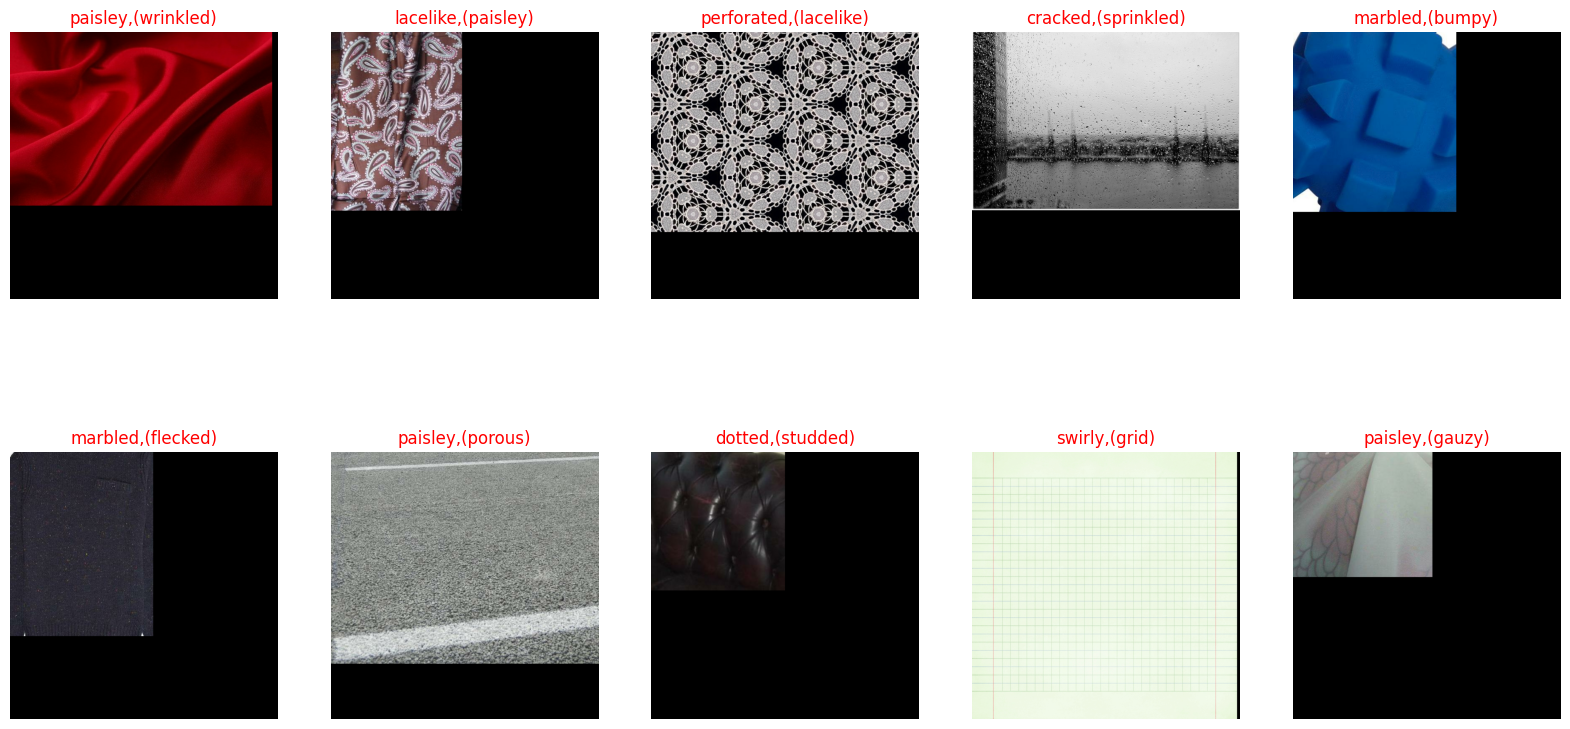

In [28]:
plt.figure(figsize=(20,10))
import random
randomly=[1,11,21,42,85,12,45,8,41,31]
for i in range(len(randomly)):
  ax = plt.subplot(2,5,i+1)
  image = valid['image'][i]
  plt.imshow(image)
  if labels[valid['label'][i]]==labels[preds[i]]:
    plt.title({labels[preds[i]]},color='green')
  else:
    plt.title(f"{labels[preds[i]]},({labels[valid['label'][i]]})",color='red')
  plt.axis("off")
plt.show()

In [29]:
json_model = resnet_model.to_json()
with open("resnet_scratch_model.json", "w") as json_file:
    json_file.write(json_model)